In [1]:
import numpy as np
import pandas as pd
import re,math
from sklearn import preprocessing
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


data1 = pd.read_excel(r'pcbi.1006752.s002.xlsx', sheet_name="Sheet1",index_col='Drug').drop('SMILES',axis=1)
data2 = pd.read_excel(r'Label_synergy4000.xlsx')

In [2]:
temp1 = []
index_l = []
for index,row in data2.iterrows():
    ct = np.array(data1.loc[row["DrugA"],:]) + np.array(data1.loc[row["DrugB"],:])
    tp = []
    for i in ct:
        if i >= 1:
            tp.append(1)
        else:
            tp.append(0)
    temp1.append(tp)
    index_l.append((row["DrugA"],row["DrugB"]))

In [3]:
def tanimoto(p,q):
    tep1=0
    tep2=0
    lenthp=int(len(p))
    for i in range(lenthp):
        a=p[i]        
        b=q[i]
        if (a==1)|(b==1):
            tep1=tep1+1
        if (a==1)&(b==1):
            tep2=tep2+1 
    c=float(tep2 / tep1)        
    return c

In [4]:
temp=[]  
for i in temp1:
    tmp=[]   
    a=np.array(i)
    for j in temp1:
        b=np.array(j)    
        tp=tanimoto(a,b)
        tmp.append(tp)
    temp.append(tmp)
Tanimoto=pd.DataFrame(temp,columns=index_l,index=index_l)

In [5]:
tptp = Tanimoto.copy()
dpdp = Tanimoto.copy()

In [6]:
gl = 0.78
# 筛高相似
while True:
    drop_status = 0
    count = 0
    drop_h = 0
    drop_l = 0
    for i in tptp.values:
        cot = 0
        for j in i:
            if j < gl:
                drop_h = count
                drop_l = cot
                drop_status = 1
                break
            cot += 1
        if drop_status == 1:
            break
        count += 1
    
    #取出对应行
    count = 0 
    for i in tptp.values:
        if count == drop_h:
            drop_h_list = i
            break
        count += 1
    
    #取出对应列
    drop_l_list = []
    for i in tptp.values:
        cot = 0
        for j in i:
            if cot == drop_l:
                drop_l_list.append(j)
            cot += 1
    
    h=np.array(drop_h_list).copy()
    l=np.array(drop_l_list).copy()
    h[h < gl]=10000
    l[l < gl]=10000
    if  np.sum(h) >= np.sum(l):
        tptp.drop(index=[tptp.columns[drop_h]],columns=[tptp.columns[drop_h]],inplace=True)
    elif np.sum(h) < np.sum(l):
        tptp.drop(index=[tptp.columns[drop_l]],columns=[tptp.columns[drop_l]],inplace=True)

    p = np.array(tptp.values).copy()
    p[p < gl]=582*582
    if  np.sum(p) < 582*582:
        break

In [7]:
gl = 0.6
# 筛低相似 
while True:
    dpdp[dpdp == 1]=-1
    drop_status = 0
    count = 0
    drop_h = 0
    drop_l = 0
    for i in dpdp.values:
        cot = 0
        for j in i:
            if j > gl:
                drop_h = count
                drop_l = cot
                drop_status = 1
                break
            cot += 1
        if drop_status == 1:
            break
        count += 1
    
    #取出对应行
    count = 0
    drop_h_list = []
    for i in dpdp.values:
        if count == drop_h:
            drop_h_list = i
            break
        count += 1
    
    #取出对应列
    drop_l_list = []
    for i in dpdp.values:
        cot = 0
        for j in i:
            if cot == drop_l:
                drop_l_list.append(j)
            cot += 1
    
    h=np.array(drop_h_list).copy()
    l=np.array(drop_l_list).copy()
    h[h > gl]=10000
    l[l > gl]=10000
    if  np.sum(h) >= np.sum(l):
        dpdp.drop(index=[dpdp.columns[drop_h]],columns=[dpdp.columns[drop_h]],inplace=True)
    elif np.sum(h) < np.sum(l):
        dpdp.drop(index=[dpdp.columns[drop_l]],columns=[dpdp.columns[drop_l]],inplace=True)
    p = np.array(dpdp.values).copy()
    p[p > gl]=35*35
    if  np.sum(p) < 35*35:
        break
dpdp[dpdp == -1]=1

In [8]:
high_similar_regiments=tptp
low_similar_regiments=dpdp
drugs_data=data2.T
drugs_data.columns=Tanimoto.index
drugs_data=drugs_data.drop('DrugA',axis=0).drop('DrugB',axis=0)

In [9]:
high_midecines = high_similar_regiments.columns[1:]
low_midecines = low_similar_regiments.columns[1:]

In [10]:

drugs_temp = []
j = 0
for i in drugs_data.columns[0:]:
    drugs_temp.append(drugs_data[i])
    j += 1

In [11]:
#预处理drugs
t = drugs_temp[0]
for i in drugs_temp[1:]:
    t = pd.concat([t,i],axis=1)
drugs = t.copy()
drugs

MK-5108 VINORELBINE SUNITINIB       5-FU SUNITINIB  \
                         SORAFENIB   SUNITINIB   MK-8776 DINACICLIB   MK-2206   
A2058_SKIN                   -9.51       -13.2      26.4       4.33      45.5   
A2780_OVARY                    2.6       -4.03      14.5      -8.16      22.5   
A375_SKIN                     15.2        11.1      29.5      -5.42      22.8   
A427_LUNG                     6.22        10.5      17.5      -7.75        18   
CAOV3_OVARY                  -16.4       -15.6      17.7      -14.3      20.1   
COLO320_LARGE_INTESTINE       5.36        16.3      10.3       4.81      22.7   
EFM192A_BREAST               -7.08       -1.72      0.83      0.312       6.3   
ES2_OVARY                     8.05        8.89      5.77       3.41      24.9   
HCT116_LARGE_INTESTINE        12.4       0.686      19.3       2.92      35.4   
HT144_SKIN                    5.79        9.68       8.4      -3.48      23.4   
HT29_LARGE_INTESTINE           4.7       -20.3      14.5      -2.54      37.3   
KPL1_BREAST                   3.97        11.3      12.7    0.00736      32.7   
LOVO_LARGE_INTESTINE          -7.2         2.6      3.41      -11.9      24.9   
MDAMB436_BREAST               4.87       -3.48      7.15       5.35      14.5   
MSTO211H_PLEURA              -6.96        9.99     -10.8       1.11     -6.04   
NCIH1650_LUNG                 11.2       0.678      1.52      -2.11      23.5   
NCIH2122_LUNG                -10.3         -15       -15       1.22      22.7   
NCIH23_LUNG                   5.46       -6.66      -7.6      -9.53      11.3   
NCIH460_LUNG                -0.127        6.71      7.37      -7.42        29   
NCIH520_LUNG                   2.7         4.2      8.75      -4.32      15.8   
OV90_OVARY                    8.04        13.7     0.933      -5.94      8.15   
OVCAR4_OVARY                 -16.2       -9.62      4.99       2.71        13   
RKO_LARGE_INTESTINE             10       -11.6     0.268       5.62      15.8   
RPMI7951_SKIN                -8.65       -22.5     -16.7      -5.69      10.3   
SKMEL30_SKIN                   9.6         4.7      10.2      -96.6      26.3   
SKMES1_LUNG                  -6.23        2.82     -12.2      -3.14      24.4   
SKOV3_OVARY                   13.5        1.51      -7.4      -13.9      31.2   
SW620_LARGE_INTESTINE          5.1        13.8      10.5      -4.57      18.4   
SW837_LARGE_INTESTINE         5.15       -5.77     -4.97      -19.6      12.9   
T47D_BREAST                   6.63       -14.4      13.1      -2.72      14.3   
UACC62_SKIN                   3.88       -10.7      18.8       3.68      34.7   
VCAP_PROSTATE                -1.48       -16.8        12       14.4      21.2   
ZR751_BREAST                 -8.66       -11.8      5.95      -13.6      14.4   
DLD1_LARGE_INTESTINE            13        15.3      6.77      -3.64      26.4   
PA1_OVARY                     4.83       -13.1      18.9      -5.73      55.4   

                         PACLITAXEL    MK-2206 MK-4827 VINORELBINE MK-5108  \
                            BEZ-235 DINACICLIB MK-8776  DINACICLIB MK-8776   
A2058_SKIN                    -5.01       9.97    76.2         -16   -4.97   
A2780_OVARY                   -3.86       1.69    21.6       -19.2    11.1   
A375_SKIN                      25.5       13.2    38.7        -123    8.95   
A427_LUNG                      4.91       7.66   -12.1       -4.42    6.89   
CAOV3_OVARY                   -15.3       19.2    22.4       -27.2   -1.16   
COLO320_LARGE_INTESTINE        21.2       7.13    13.5        17.4   -48.4   
EFM192A_BREAST                -30.8      -9.49     -12       -13.6    16.8   
ES2_OVARY                      4.26       14.7     -53        11.5     3.9   
HCT116_LARGE_INTESTINE        -6.13       4.01    17.4       -25.1    8.67   
HT144_SKIN                     27.1       6.52    21.8     -0.0348   -6.36   
HT29_LARGE_INTESTINE           1.02       15.5    7.33       -29.9   0.265   
KPL1_BREAST    

In [12]:
#zscore标准化
values = drugs.values            #Dataframe转换为Array
values = values.astype('float32')       #定义数据类型
scaler = preprocessing.StandardScaler() #创建Scaler对象
temp = scaler.fit_transform(values)     #稀疏矩阵  
drugs=pd.DataFrame(temp,columns=drugs.columns) #将Array还原为Dataframe，保持行列名

In [13]:
#提取药物对对应高相似团
high_list = []
for i in high_midecines:
    high_list.append(drugs[i])
r = high_list[0]
for i in high_list[1:]:
    r = pd.concat([r,i],axis=1)
high_result = r

In [14]:
#提取药物对对应低相似团
low_list = []
for i in low_midecines:
    low_list.append(drugs[i])
r = low_list[0]
for i in low_list[1:]:
    r = pd.concat([r,i],axis=1)
low_result = r

In [15]:
#计算高相似细胞团的斯皮尔曼相关性系数
spearman_h=high_result.corr('spearman')

#计算低相似细胞团的斯皮尔曼相关性系数
spearman_l=low_result.corr('spearman')

In [16]:
arr1 = np.triu(np.array(spearman_h),k=1)
arr2 = np.triu(np.array(spearman_l),k=1)

In [17]:
#取非零元素
high_res = arr1.ravel()[np.flatnonzero(arr1)]
low_res = arr2.ravel()[np.flatnonzero(arr2)]
result_compare = pd.DataFrame([high_res.T,low_res.T],index=['high','low']).T
result_compare_lst = []
for index, line in result_compare.iteritems():
    result_compare_lst.append(np.array(line.dropna()))

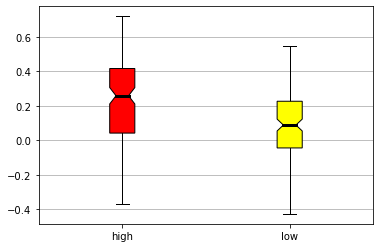

In [18]:
fig = plt.subplot(1,1,1)
bplot = fig.boxplot(result_compare_lst,
                meanline='black',
                notch=True,
                vert=True, 
                patch_artist=True)
#颜色填充
colors = ['red', 'yellow']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

for median in bplot['medians']:
    median.set(color='black', linewidth=3)
    
fig.yaxis.grid(True) #在y轴上添加网格线
fig.set_xticks([y+1 for y in range(len(result_compare_lst))] ) 
#fig.set_xlabel('细胞团') #设置x轴名称
#fig.set_ylabel('ylabel') #设置y轴名称

# 添加刻度
# 添加刻度名称，我们需要使用 plt.setp() 函数：

# 加刻度名称
plt.setp(fig, xticks=[1,2],
         xticklabels=['high','low'])
# 我们的刻度数是哪些，以及我们想要它添加的刻度标签是什么。
        
plt.show()